# Comparing Traditional Time-Series Forecasting Methods with Time-Series Transformers

## Introduction
In the recent year, there has been a significant shift in the field of time-series forecasting. some may said the ImageNet moment for time-sereis. Major tech companies such as Amazon, Google, and Salesforce, among others, have introduced open-source transformers specifically designed for time-series forecasting. These models claim to outperform traditional forecasting methods in accuracy and efficiency. In this notebook, we will explore and compare traditional time-series forecasting methods like ARIMA, Exponential Smoothing, and Prophet with these new time-series transformers, specifically Chronos and Moirai-MoE, to predict the actual price of energy.

## Dataset

The dataset used in this study comprises weather and energy data from Spain, collected between 2014 and 2019. It includes various features such as temperature, wind speed, energy generation, and consumption. Our target variable is the actual price of energy, which we aim to forecast using different methodologies.

### Exploratory Data Analysis (EDA)

During the EDA phase, we will conduct data preprocessing and feature extraction specifically tailored for time-series data. This involves handling missing values, identifying and addressing non-stationary series, and extracting key features such as seasonal patterns, trends, and autocorrelation (ACF). These steps are crucial for understanding the underlying structure of the data and preparing it for more effective modeling.


We will apply each forecasting method to the dataset and evaluate their performance using metrics such as RMSE and MAPE.

## Traditional Methods
1. **ARIMA (AutoRegressive Integrated Moving Average)**
2. **Exponential Smoothing**

These methods will be applied to the dataset to establish a baseline performance for forecasting.

## Time-Series Transformers

1. **Chronos**
2. **Moirai-MoE**

The transformers used in this comparison are pre-trained on other datasets and fine-tuned for our specific task. These models will be evaluated in a zero-shot setting, where they are directly applied to our dataset without additional training.

## Results and Comparison

- **Performance Metrics**: We will calculate RMSE, MAPE, and other relevant metrics to quantify the accuracy of each method.
- **Visual Comparisons**: Plots will be generated to visually compare the forecasts from traditional methods and transformers.

## Conclusion

The final section will discuss the strengths and weaknesses of each approach, highlighting the conditions under which each method performs best.


In [109]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import math
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


## Dataset Overview

The dataset used in this study spans four years, from 2014 to 2019, and includes various aspects of electrical consumption, generation, pricing, and weather data for Spain. This comprehensive dataset was compiled from several sources to provide a detailed view of the energy market and its influencing factors during this period.

### Data Sources
- **Electrical Consumption and Generation**: The data was sourced from ENTSOE, a public portal that provides data from Transmission Service Operators (TSOs). This includes detailed records of energy consumption and various methods of energy generation across Spain.
- **Settlement Prices**: Pricing data was retrieved from the Spanish TSO, Red Eléctrica de España. This provides the actual settlement prices for energy, which is crucial for understanding the market dynamics.
- **Weather Data**: Weather information was obtained from the Open Weather API and covers the five largest cities in Spain. This data includes various meteorological parameters, which are essential 


In [110]:
# read weather datasets, turn the dt_iso column into a datetime object
df_weather = pd.read_csv(
    'datasets/weather_features.csv'
)
# read energy dataset, turn the time column into a datetime object
df_energy = pd.read_csv(
    'datasets/energy_dataset.csv'
)
df_energy['time'] = pd.to_datetime(df_energy['time'],utc=True)
# Set the 'time' column as the index
df_energy.set_index('time', inplace=True)

df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'],utc=True)
df_weather['time'] = df_weather['dt_iso']
df_weather['time'] = pd.to_datetime(df_weather['time'],utc=True)
df_weather.index = df_weather['time']
df_weather = df_weather.drop(['dt_iso'],axis=1)


### Exploratory Data Analysis (EDA)

In this section, we will begin by cleaning and preprocessing the energy dataset. First, we will examine the dataset using the `describe()` method to obtain an overview of the statistical properties of each column. Here are some of the columns we will inspect:

- **Generation Data**: This includes various energy generation methods such as biomass, fossil fuels (coal, gas, oil), hydro (pumped storage, run-of-river, and water reservoir), nuclear, wind, solar, and waste. These columns reflect the energy generation by different sources across Spain.
- **Forecast Data**: This includes the forecast values for solar, wind, and total load on a day-ahead basis.
- **Actual Energy Load and Prices**: These include the total load , as well as the day-ahead energy prices, which provide insights into the real-time energy market dynamics that we will want to predict.


In [111]:

# we will start analyzing the energy dataset
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


We can see a lot of things from the `describe()` function about the dataset. First, we can see that there are some columns with only NaN values in them. This suggests that these columns might not contain any useful information for our analysis. We will calculate the percentage of NaN values in these columns to identify those that have a significant proportion of missing data. This will help us determine if there are other columns with a considerable amount of NaN values that might need to be dropped or handled with imputation. The goal is to clean the dataset and retain only the most useful features for building our models.


In [112]:
# Calculate the number of missing values for each column
missing_counts = df_energy.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentages = (df_energy.isna().mean() * 100).sort_values(ascending=False)

missing_percentages.head(5)


generation hydro pumped storage aggregated    100.000000
forecast wind offshore eday ahead             100.000000
total load actual                               0.102669
generation waste                                0.054187
generation marine                               0.054187
dtype: float64

As observed, there are two columns that contain only NaN values(generation hydro pumped storage aggregated,forecast wind offshore eday ahead)), while the remaining columns have a relatively low percentage of missing values. We will keep the relatively low percentage columns for now and drop the NaN columns.


In [113]:
df_energy = df_energy.drop(['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'],axis=1)


Eariler we saw on the df_energy.describe() that there are some colums with only 0 values, so they dont give us any information. so we will drop them also.

In [114]:

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation marine','generation wind offshore','generation geothermal'],axis=1)

### Dropping Forecast Columns

In this step, we drop all columns related to forecast data. These columns contain predicted values that are not useful for our analysis, as our goal is to forecast the energy prices ourselves. Keeping them in the dataset could introduce unnecessary biases or inaccuracies. Therefore, we remove any columns whose names contain the word "forecast" to ensure we only work with the relevant data for our own forecasting task.


In [115]:
to_drop = [col for col in df_energy.columns if 'forecast' in col]
print(to_drop)
df_energy = df_energy.drop(to_drop, axis=1)

['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast']


In this step, we calculate the number of missing (NaN) values for each column in the dataset. We then plot a bar chart to visualize the count of missing values for columns that have missing data.

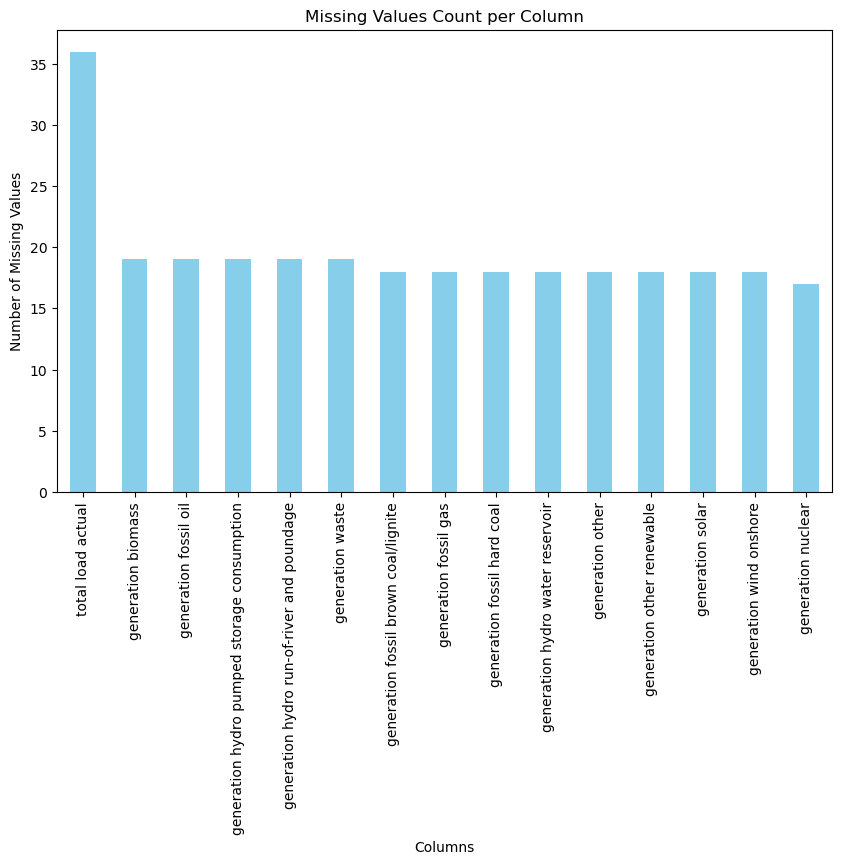

In [116]:
missing_count = df_energy.isna().sum()

# Plotting the missing values count
plt.figure(figsize=(10, 6))
missing_count[missing_count > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Count per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.show()


As we can see, comparing to a 35045 samples, the column with the most nan values have only 34 NaN, so it not a critical error.

In [117]:
# # Select numerical columns for plotting
# columns = df_energy.select_dtypes(include=['float64', 'int64']).columns

# # Calculate grid size (e.g., 2 columns per row)
# ncols = 4
# nrows = int(np.ceil(len(columns) / ncols))

# # Create subplots
# f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
# f.suptitle('Boxplots of Energy Features', weight='bold', fontsize=25)

# # Flatten axes array and iterate over columns
# axes = axes.flatten()
# for i, col in enumerate(columns):
#     sns.boxplot(data=df_energy, x=col, ax=axes[i], color='#cc444b', width=0.5)
#     axes[i].set_title(f"Boxplot of {col}", fontsize=12)
#     axes[i].set_xlabel('')  # Remove x-axis label for cleanliness

# # Remove unused subplots if columns are fewer than grid slots
# for j in range(i + 1, len(axes)):
#     f.delaxes(axes[j])

# # Adjust layout
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
# plt.show()

if we look closely, we are see some outliers, not alot of them though. we will fill them up with a 
FIGURE OUT



In this step, we create a plot of the 'Total Load Actual' against time to visualize the data over a specific time range. By zooming in on a particular period (from '2015-01-01' to '2015-02-02'), we can better observe the trends, patterns, and any potential gaps or anomalies in the data. This visualization will help us understand the behavior of the 'Total Load Actual' variable, which is crucial for deciding how to handle missing values and perform imputation. The goal is to examine the time-series data to inform our approach to filling any gaps, whether through interpolation or other methods.


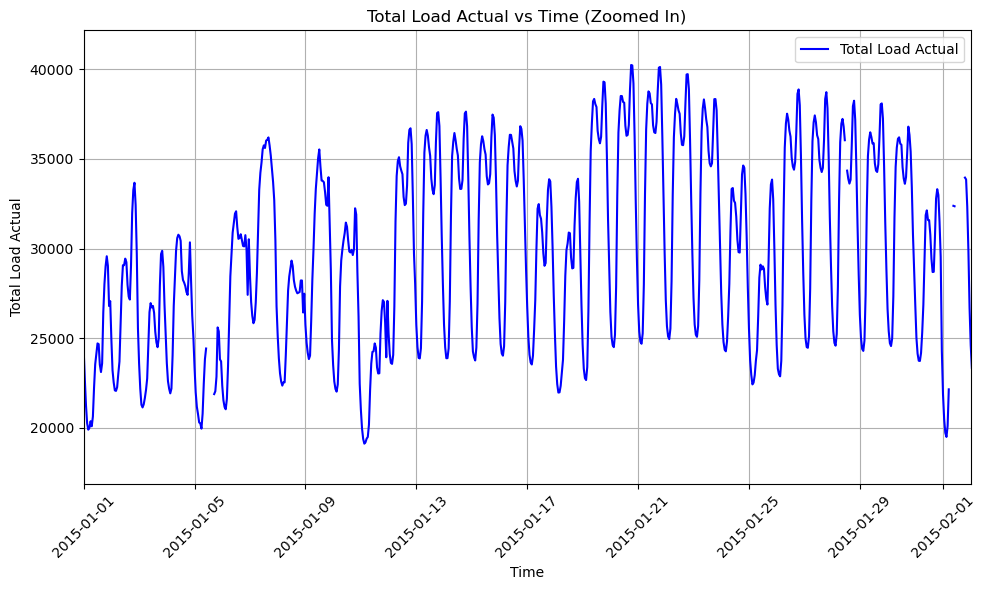

In [118]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-02')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-02'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We can see that in the beginning of 2015-01-05 there is a missing value.
Time series data relies on the order and continuity of time-based observations. If you remove rows with missing data, you can break this continuity, leading to gaps in your time series, also , in more techinal approach, Many time series models (e.g., ARIMA, LSTM) require the data to be continuous and use previous observations to make predictions. Dropping rows can disturb this temporal relationship, leading to poor model performance.
so we will need to fill the missing values, as we can see in the plot we just plotted that the data of Load Actual is linear. so a good approach would be to use linear interplation in here.
2 more possible approachs that are common in time-series data is fill forward that will replaces NaN with the immediat next value, and backword fill thah replaces NaN with the immediate previous value.
The reason I am choosing linear interplation its becuase, as we can see there is a somekind of gap between night and day, which linear interploate will solve but the other methods can make a bigger gap and less smoother.

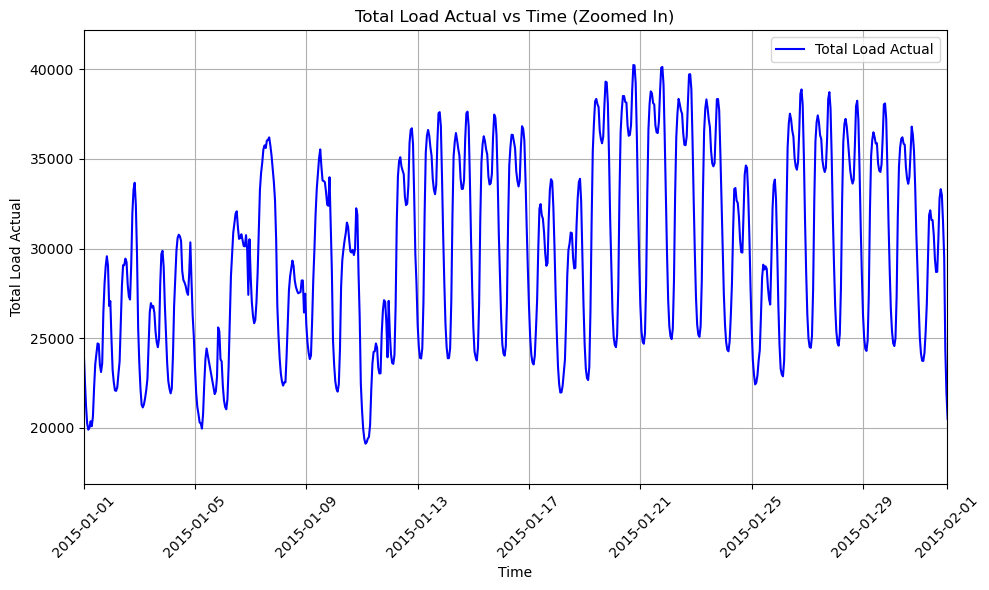

In [120]:

df_energy['total load actual'] = df_energy['total load actual'].interpolate(method='linear')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-01')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

we can see that missing value is filled and the line looks "natural".

Now we will go all over our features and we would try to figure out how should we fill the missing values.

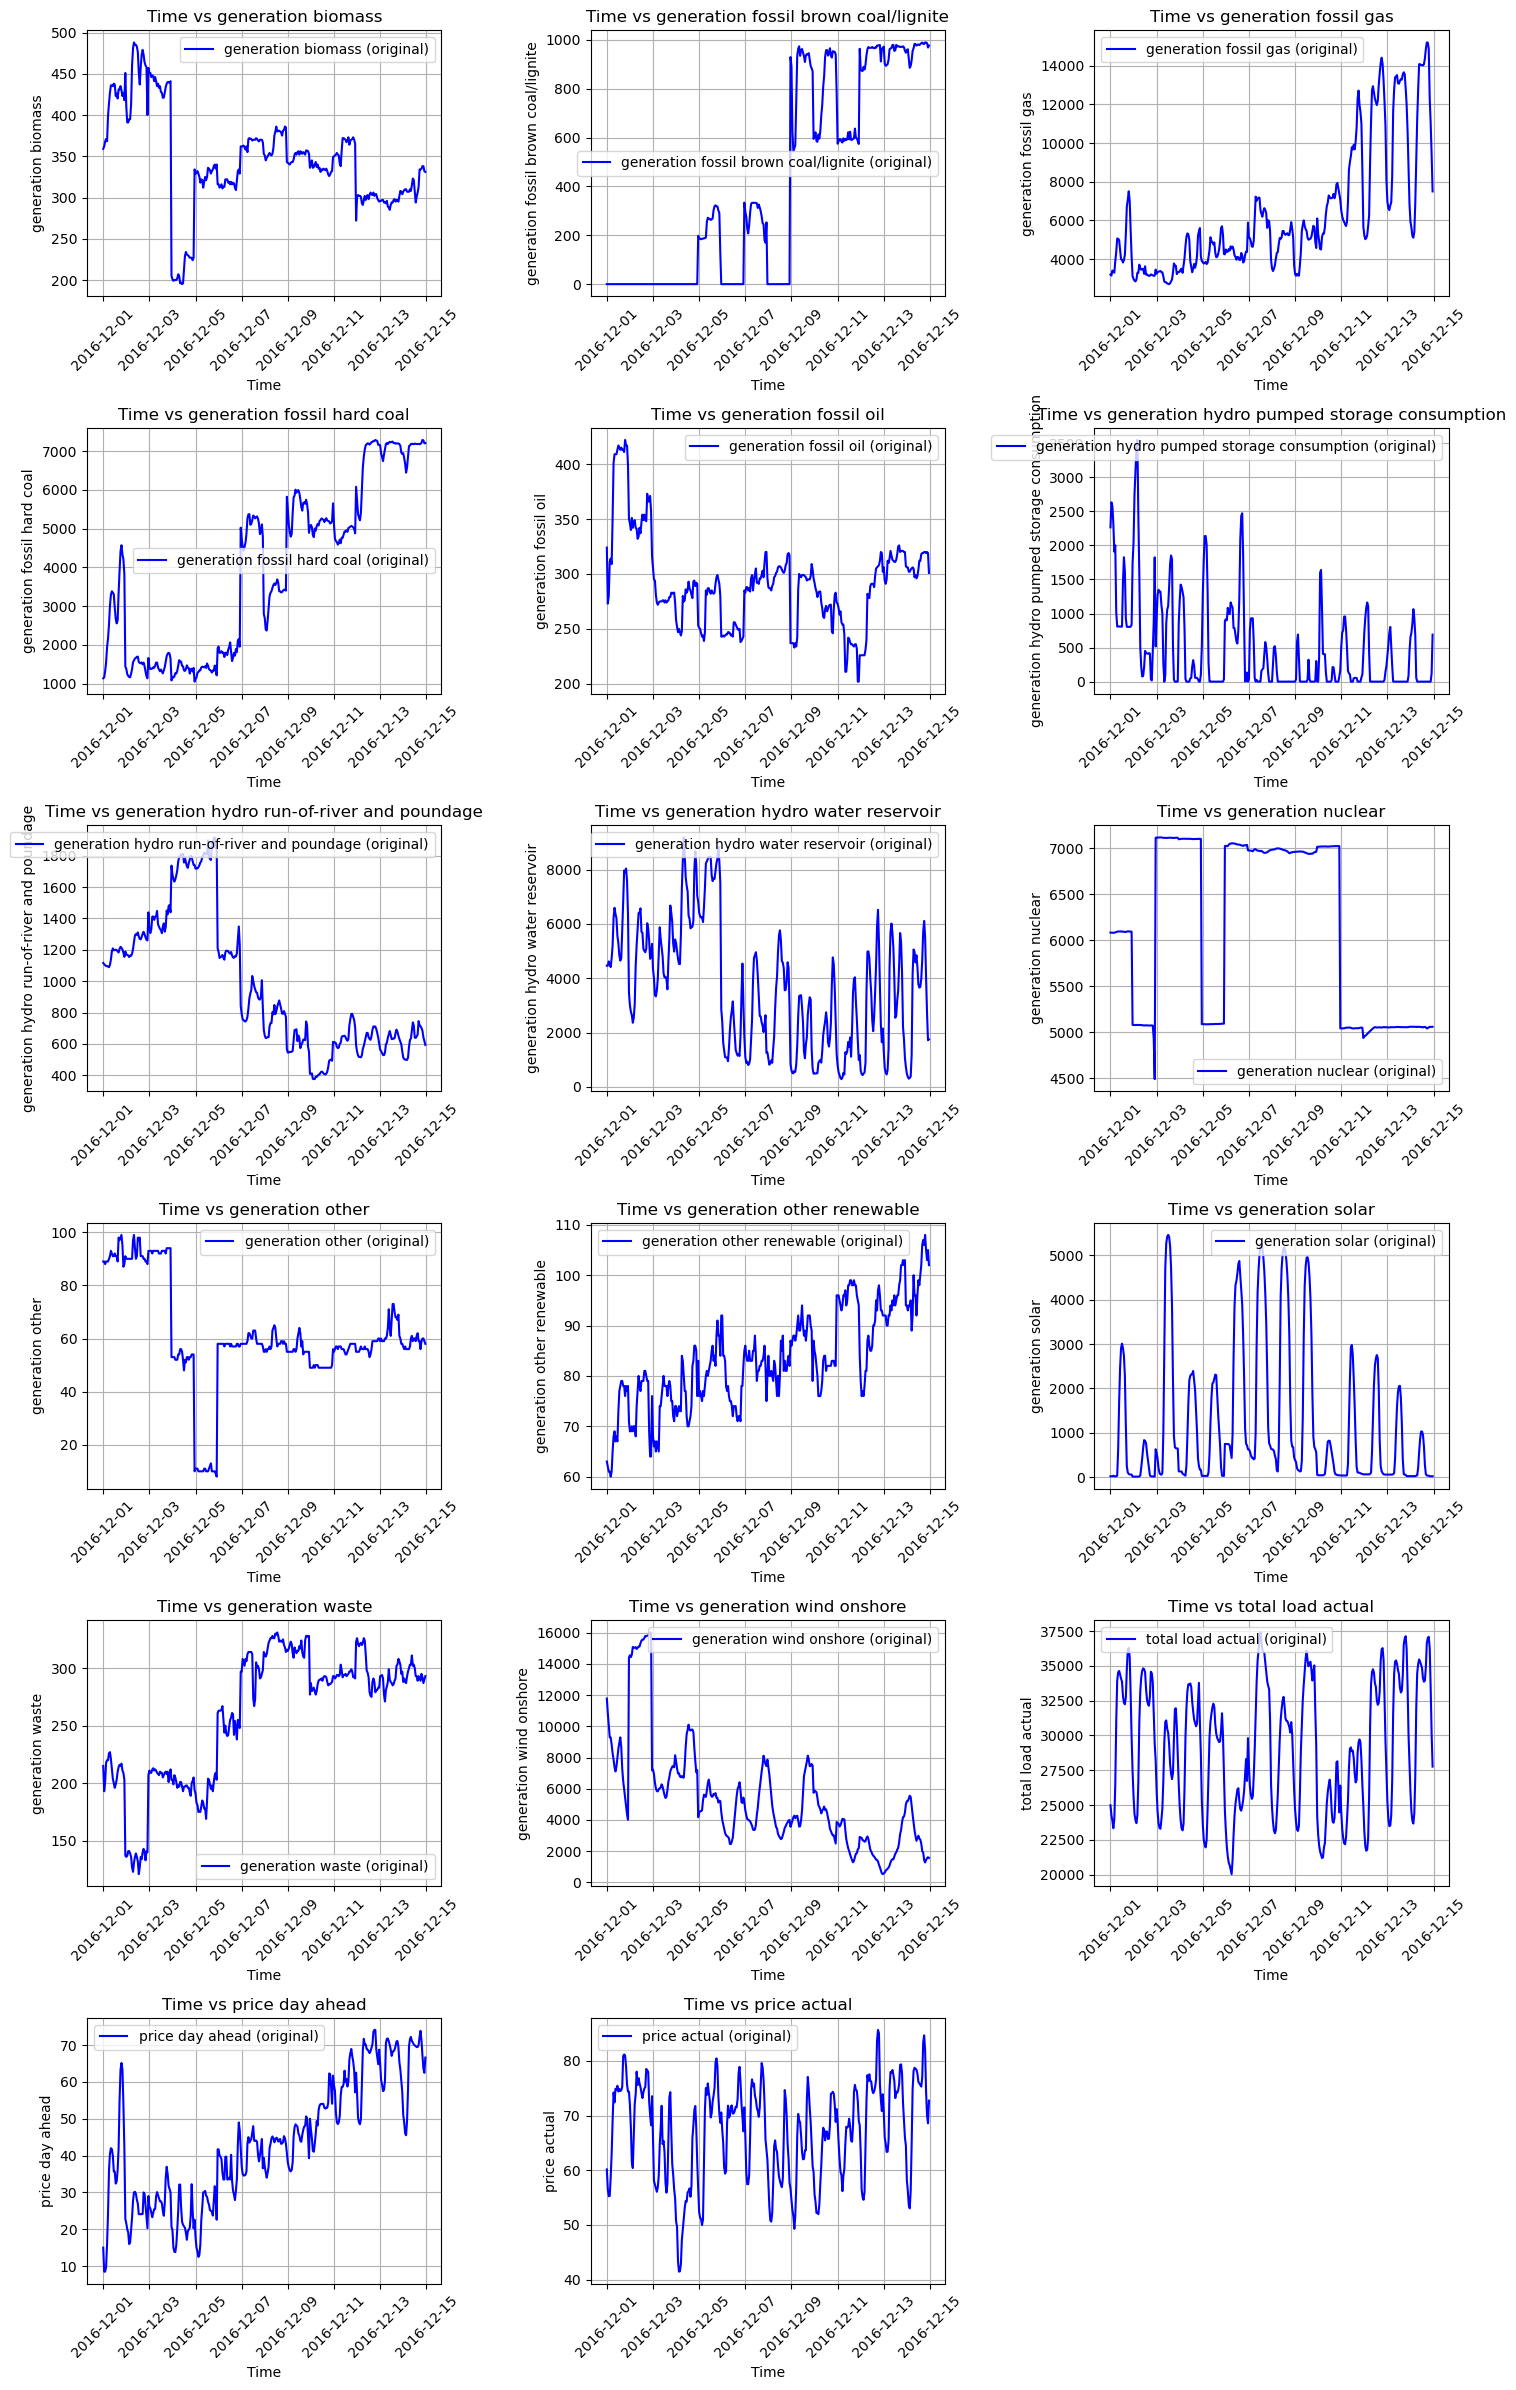

In [121]:
start_date = pd.Timestamp('2016-12-01 00:00:00', tz='UTC')
end_date = pd.Timestamp('2016-12-14 23:59:59', tz='UTC')

# Filter the DataFrame to include only the specific two-week period
df_two_weeks = df_energy.loc[start_date:end_date]
df_two_weeks.head()

# Get the number of columns to plot
columns = df_two_weeks.columns
n_columns = len(columns)

# Calculate the grid size
nrows = math.ceil(n_columns / 3)  # 3 columns per row
ncols = 3  # Fixed number of columns

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten to easily iterate over

for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(df_two_weeks.index, df_two_weeks[column], label=f"{column} (original)", color='blue')
    
    # Customize the plot
    ax.set_title(f"Time vs {column}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{column}")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### Linear Interpolation for Missing Values

After plotting all the features and examining the time-series data, it appears that linear interpolation is the most suitable method to fill in the missing values. Linear interpolation works by estimating missing values based on the linear trend between available data points, making it a natural choice for time-series data where values are expected to change gradually over time.

By applying linear interpolation, we are ensuring that the filled values follow the same trend as the surrounding data points, rather than introducing artificial patterns or assumptions. This method is effective when the data does not exhibit sharp fluctuations or irregular patterns that would require more complex imputation methods, like polynomial or spline interpolation.

Thus, we use the `interpolate()` function with the `linear` method to fill the missing values and preserve the continuity of the time-series data.


In [122]:
df_energy = df_energy.interpolate(method='linear')

In [123]:
null_percentage = df_energy.isnull().sum()/len(df_energy) * 100   
print(null_percentage)
# we can see there is no more missing values in the dataset

generation biomass                             0.0
generation fossil brown coal/lignite           0.0
generation fossil gas                          0.0
generation fossil hard coal                    0.0
generation fossil oil                          0.0
generation hydro pumped storage consumption    0.0
generation hydro run-of-river and poundage     0.0
generation hydro water reservoir               0.0
generation nuclear                             0.0
generation other                               0.0
generation other renewable                     0.0
generation solar                               0.0
generation waste                               0.0
generation wind onshore                        0.0
total load actual                              0.0
price day ahead                                0.0
price actual                                   0.0
dtype: float64


In [124]:
zeros_percentage = (df_energy == 0).sum()/len(df_energy) * 100
print(zeros_percentage)

generation biomass                              0.011408
generation fossil brown coal/lignite           30.013689
generation fossil gas                           0.002852
generation fossil hard coal                     0.008556
generation fossil oil                           0.008556
generation hydro pumped storage consumption    35.974219
generation hydro run-of-river and poundage      0.008556
generation hydro water reservoir                0.008556
generation nuclear                              0.008556
generation other                                0.011408
generation other renewable                      0.008556
generation solar                                0.008556
generation waste                                0.008556
generation wind onshore                         0.008556
total load actual                               0.000000
price day ahead                                 0.000000
price actual                                    0.000000
dtype: float64



## Data Cleaning Summary: df_energy Dataset
Generation fossil brown coal/lignite: This column represents electricity production from lignite, a low-grade coal. While it is an affordable and locally abundant energy source, it is among the least environmentally friendly due to high carbon emissions and inefficiency. Spain's significant investments in renewable energy sources, such as wind, solar, and hydropower, have reduced reliance on lignite. As a result, its use is often limited to periods when renewable generation and other cleaner options cannot meet demand, explaining the presence of zeros in 30% of the data.

Hydro pumped storage consumption: This column shows 35% zeros, which is expected. Pumped storage is utilized only during energy surplus periods to store energy, remaining inactive when supply and demand are balanced or when conditions do not require its operation.

The percentage of zeros in these columns is reasonable and does not indicate any inaccuracies in the data.

With these steps, the df_energy dataset is sufficiently cleaned for further analysis. Future work may include additional feature engineering and processing as needed.

Now, let's proceed to clean the weather dataset.

In [147]:
df_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,weather_main
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.004846,24.344057,1.287417
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.224547,30.339522,2.208143
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,16.000000,1.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,40.000000,1.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,21.500000,100.000000,11.000000


In the data set we have 5 major cities in Spain that been sampled through 2014-2018, as we can see they have been sampled hourly, the same as the df_energy dataset which is excellent for us.
The length of the dataframes is 178396 which is 35064(the lenght of the df_energy dataset) * 5.

as we can see here -


In [148]:
print(len(df_energy.index.unique()))
print(len(df_weather.index.unique()))

35064
35064


As we know, in time-series data, duplicates are not allowed. Additionally, when extracting each city as its own feature, duplicates can cause issues. 

In this case, we observe that the total number of unique rows is 35,064, but for each city, we have more than 35,064 rows. This indicates that duplicates exist, and we need to remove them in order to proceed correctly.


In [149]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
def count_duplicate_times_by_city(grouped):
    for city, group in grouped:
    # Check for duplicates in the 'time' column
        duplicated_count = group['time'].duplicated().sum()
        print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
        print(f"Number of rows is {len(group)}")
        duplicated_rows = group[group['time'].duplicated(keep=False)]
count_duplicate_times_by_city(grouped)


City:  Barcelona, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Bilbao, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Madrid, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Seville, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Valencia, Number of duplicated rows based on 'time': 0
Number of rows is 35064


In [150]:
# Group by 'time' and 'city_name' and filter for groups that have more than one row
duplicated_rows = df_weather[df_weather.duplicated(subset=['time', 'city_name'], keep=False)]

# Display the rows
print(duplicated_rows.head(10))


Empty DataFrame
Columns: [city_name, temp, temp_min, temp_max, pressure, humidity, wind_speed, wind_deg, rain_1h, snow_3h, clouds_all, weather_main, time]
Index: []


As we can see, and after some manual(is it enough?) digging, The duplicated row mostly have the same values for the other columns.
so I will drop duplicates with keeping the first row(meaning that we will delete all the other rows that have the same 'time' and 'city_name')

In [151]:

df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')  # Keep the last occurrence


In [152]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
def count_duplicate_times_by_city(grouped):
    for city, group in grouped:
    # Check for duplicates in the 'time' column
        duplicated_count = group['time'].duplicated().sum()
        print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
        print(f"Number of rows is {len(group)}")
        duplicated_rows = group[group['time'].duplicated(keep=False)]

count_duplicate_times_by_city(grouped)
    

City:  Barcelona, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Bilbao, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Madrid, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Seville, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Valencia, Number of duplicated rows based on 'time': 0
Number of rows is 35064


In [153]:
zeros_percentage = (df_weather == 0).sum()/len(df_weather) * 100
print(zeros_percentage)

city_name        0.000000
temp             0.000000
temp_min         0.000000
temp_max         0.000000
pressure         0.001141
humidity         0.035934
wind_speed      10.335957
wind_deg        13.888889
rain_1h         90.079854
snow_3h         99.847707
clouds_all      46.777892
weather_main    47.153776
time             0.000000
dtype: float64


as we can see, the rain_3h(3 hours of raining) is a data that already contanied in the rain_1h(1 hour of raining), so, to remove the redundancy we will remove it.
also, we will take a look at the other columns and figure out if there is some more cleaning we need to do.

In [154]:
df_weather = df_weather.drop(['rain_3h'],axis=1)
# df_weather.info()
# we see that there is some float64 and there is some int64, we will convert the int64 to float64
for col in df_weather.select_dtypes(include=['int64']).columns:
    df_weather[col] = df_weather[col].astype('float64')
df_weather.info()

KeyError: "['rain_3h'] not found in axis"

All the columns but weather_id,weather_meain,weather dscription and weather_icon and very self-explanibale. 
so now we will try to understand what information each of these columns give us and we need them all.
if we look at the data bases in the kaggle there is a brief explantion for each column.
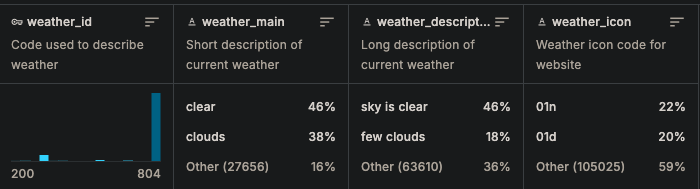



In this step, we encode the categorical features `weather_main` and `weather_description` in the `df_weather` DataFrame using `LabelEncoder`. This transformation converts the textual weather descriptions into numeric labels, making them suitable for correlation analysis and machine learning algorithms.

We print the unique encoded values for both `weather_main` and `weather_description` to understand the range of the encoded labels. Then, we calculate the correlation between `weather_main` and `weather_id` to check if these features convey similar information.

Since the correlation between `weather_main` and `weather_id` is very high, we decide to drop the `weather_id` column to avoid redundancy. Additionally, we drop the `weather_icon` column as it is not relevant for our analysis, and the `weather_description` column because its high specificity could lead to overfitting in our model.

This preprocessing step ensures that we retain only the most informative features while reducing potential noise and redundancy in our dataset.


In [ ]:

le = LabelEncoder()
# Encode categorical features
df_weather['weather_main'] = le.fit_transform(df_weather['weather_main'])
df_weather['weather_description'] = le.fit_transform(df_weather['weather_description'])
print(df_weather['weather_main'].unique())
print(df_weather['weather_description'].unique())
# Print the correlation between `weather_main` and `weather_id`
print(f"Correlation between weather_main and weather_id: {df_weather['weather_main'].corr(df_weather['weather_id'])}")

# as we can see the correlation is very high, we will drop the weather_id column, also the weather_icon column(not relevant for us) and weathers_description(too much specific can give us overfitting)
df_weather = df_weather.drop(['weather_id', 'weather_icon', 'weather_description'], axis=1)


Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h', 'clouds_all',
       'weather_id', 'weather_main', 'weather_description', 'weather_icon',
       'time'],
      dtype='object')
[ 0  1  7  6 11  2  4  8  5  9  3 10]
[33  3 30  0 21 13 20  7 19  8 31 42 39 40 41 25 38 12 10  4  1 35  6  5
 24 11 17 36 14 18 28  9 34 27 32 15 16 23 26 29 22  2 37]
Correlation between weather_main and weather_id: -0.8783431110073787



In this step, we prepare the dataset for correlation analysis by dropping non-numeric columns such as `city_name` and `time`, which are not relevant for correlation computation. We then calculate the correlation matrix for the remaining features in the `df_weather` DataFrame.

To visualize the correlations, we plot a heatmap using `seaborn`. The heatmap displays the correlation coefficients between different features, with values ranging from -1 to 1. A correlation close to 1 indicates a strong positive relationship, while a correlation close to -1 indicates a strong negative relationship. Values near 0 suggest no linear relationship.

The purpose of this correlation map is to identify features that are highly correlated with each other. When two features have a high correlation, one of them can often be dropped without losing much information. This step helps in reducing multicollinearity, simplifying the model, and improving its performance by retaining only the most informative features.


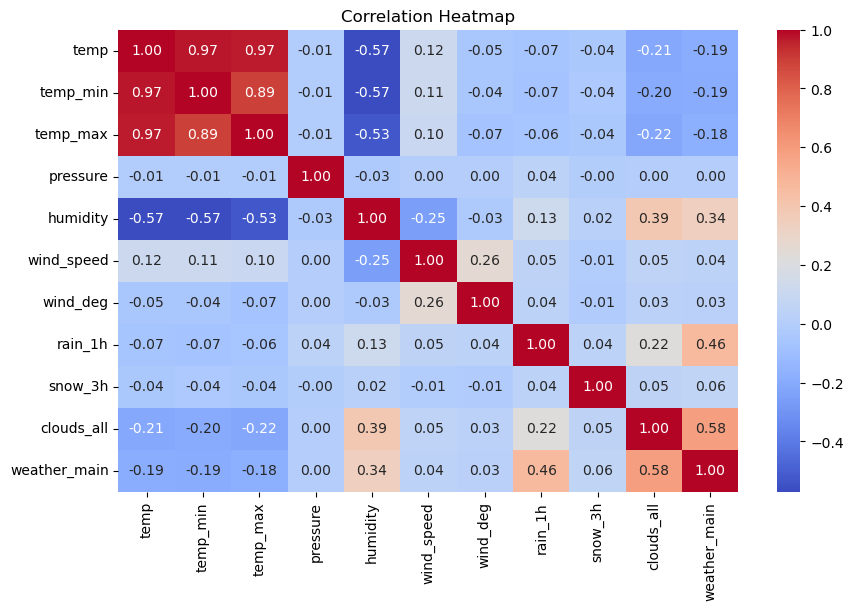

In [ ]:
df_for_cor = df_weather.drop(['city_name','time'],axis=1)
corr = df_for_cor.corr()
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [29]:
df_weather.drop(['temp_min','temp_max'],axis=1,inplace=True)

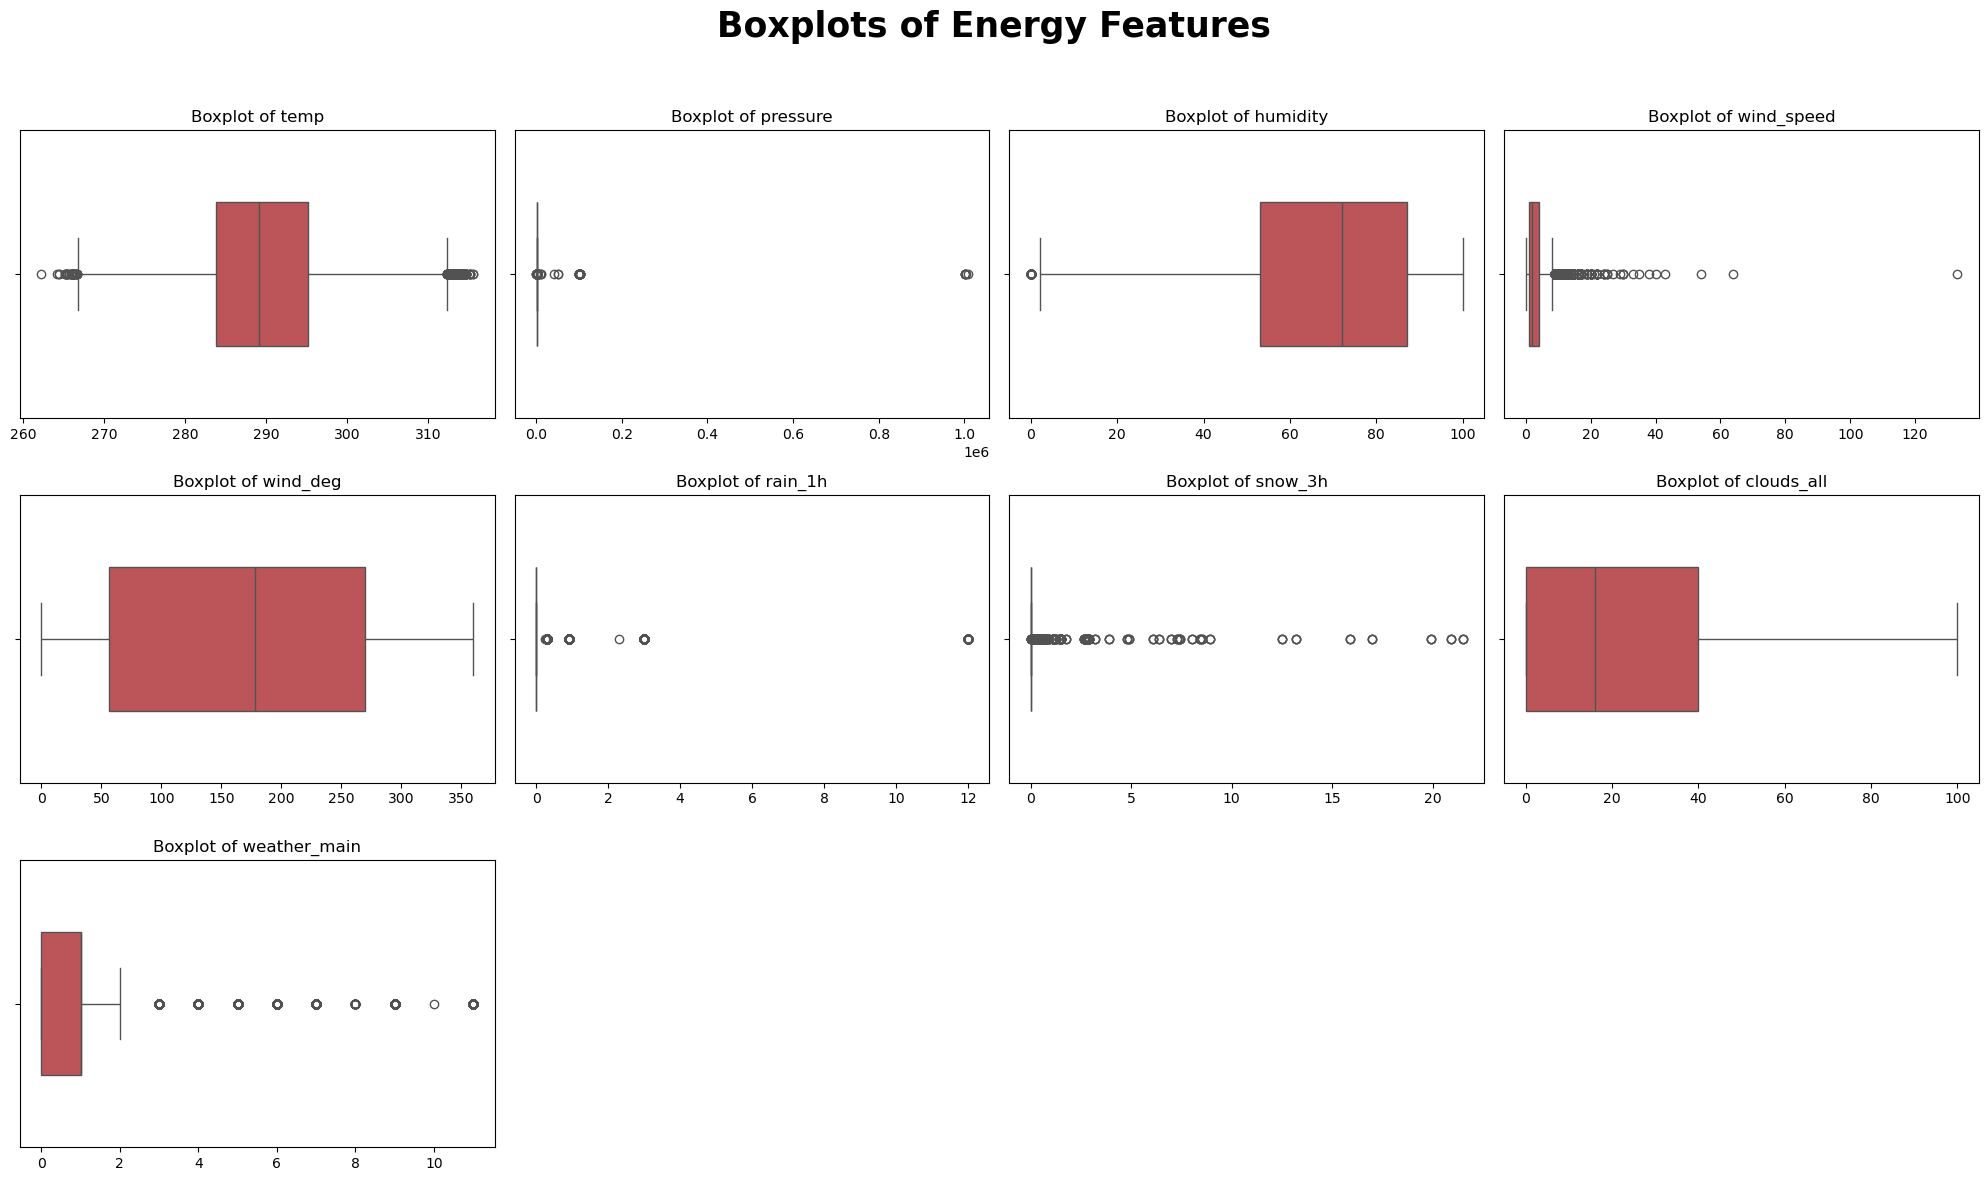

In [ ]:
# Select numerical columns for plotting
columns = df_weather.select_dtypes(include=['float64', 'int64']).columns

# Calculate grid size (e.g., 2 columns per row)
ncols = 4
nrows = int(np.ceil(len(columns) / ncols))

# Create subplots
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
f.suptitle('Boxplots of Energy Features', weight='bold', fontsize=25)

# Flatten axes array and iterate over columns
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(data=df_weather, x=col, ax=axes[i], color='#cc444b', width=0.5)
    axes[i].set_title(f"Boxplot of {col}", fontsize=12)
    axes[i].set_xlabel('')  # Remove x-axis label for cleanliness

# Remove unused subplots if columns are fewer than grid slots
for j in range(i + 1, len(axes)):
    f.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

The noraml pressure level at sea level is about 1000 hPa, at the dead sea, where is the higgest pressure there is about 1100 hPa, so more then that its an outlier. and less then 700 hPa also outlier.
also, wind speed is in m/s, then to have 50 m/s is a high as 180 km/h wind, which is very very high. so, we will define wind more then 50 m/s is an outlier.
for presure we will use mean because pressure have a solid values who are not range so much.
for wind we will calculate the 95th percentile of wind speed and if its more then the 99 percentile we will replace the value to be the 95 percentile.

In [31]:
mean_pressure = df_weather['pressure'].mean()
df_weather.loc[df_weather['pressure'] > 1105, 'pressure'] = mean_pressure
df_weather.loc[df_weather['pressure'] < 700, 'pressure'] = mean_pressure
# Calculate the 95th percentile of wind speed


upper_limit = np.percentile(df_weather['wind_speed'], 99)

# Replace values above the 95th percentile with the 95th percentile value
df_weather.loc[df_weather['wind_speed'] > upper_limit, 'wind_speed'] = upper_limit


All the other features doesnt seem to have a not reasonable outlier. so we will keep them.

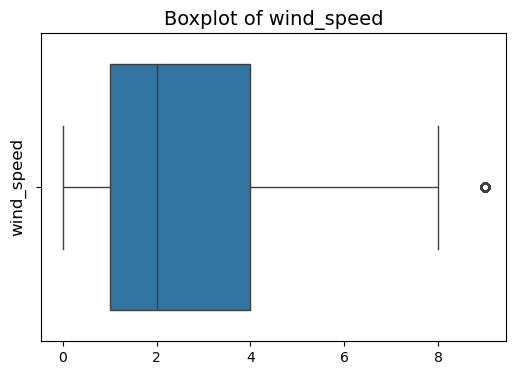

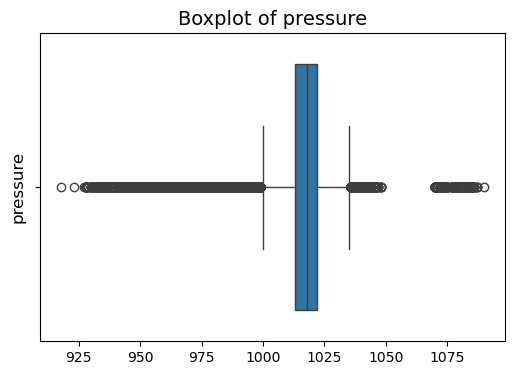

In [ ]:
# Select numerical columns for plotting
columns = df_weather[['wind_speed','pressure']]

# Loop through each column and create a boxplot
for column in columns:
    plt.figure(figsize=(6, 4))  # Set the figure size
    sns.boxplot(x=df_weather[column])
    
    # Customize the plot
    plt.title(f'Boxplot of {column}', fontsize=14)
    plt.ylabel(column, fontsize=12)
    plt.xlabel('')  # No need for an x-axis label as it's a single feature
    
    # Show the plot
    plt.show()

In [33]:
df_weather['wind_speed'].max()

9.0

In [ ]:
# Get the unique cities
cities = df_weather['city_name'].unique()

# Create a dictionary to store DataFrames for each city
city_datasets = {city: df_weather[df_weather['city_name'] == city].copy() for city in cities}

# Reset index once for each city dataframe
for city, city_df in city_datasets.items():

    city_df.drop(['time'],axis=1,inplace=True)
    for col in city_df:
        city_df[f"{col}_{city}"] = city_df[col]
        city_df.drop(col, axis=1, inplace=True)

# Reset index for the merged dataframe as well
merged_df = df_energy.copy()

# Merge city dataframes with the energy dataframe
for city, city_df in city_datasets.items():
    merged_df = pd.merge(merged_df, city_df,left_index=True,right_index=True, how='outer')

print(merged_df.head())

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:0

In [35]:
# only one row at 2014
# merged_df.drop(merged_df[merged_df['year'] == 2014].index, inplace=True)

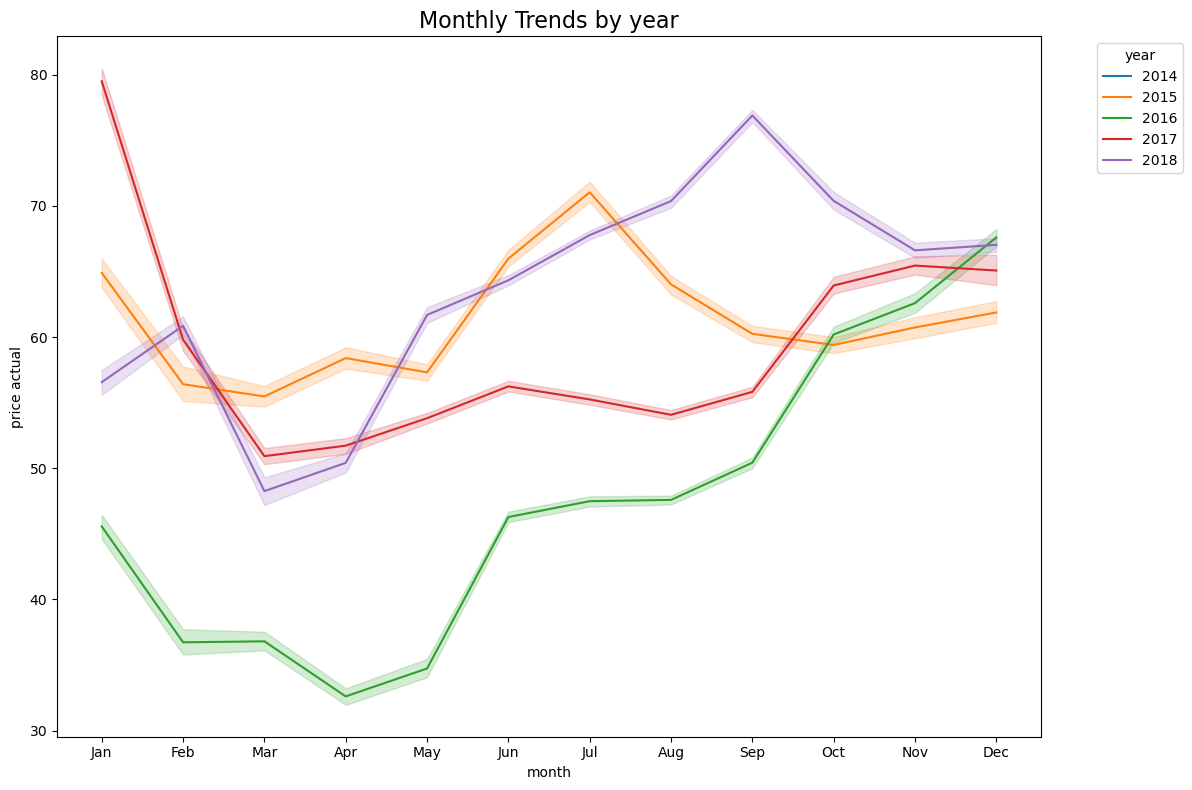

In [ ]:

# If you already have a DatetimeIndex:
# Create a new column for Year and Month
merged_df['year'] = merged_df.index.year
merged_df['month'] = merged_df.index.strftime('%b')  # Extract month names (e.g., "Jan", "Feb")

# Ensure the months are sorted in order
merged_df['month'] = pd.Categorical(merged_df['month'], 
                              categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                              ordered=True)
merged_df.columns
# Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='month', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Monthly Trends by year', fontsize=16)
plt.xlabel('month')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


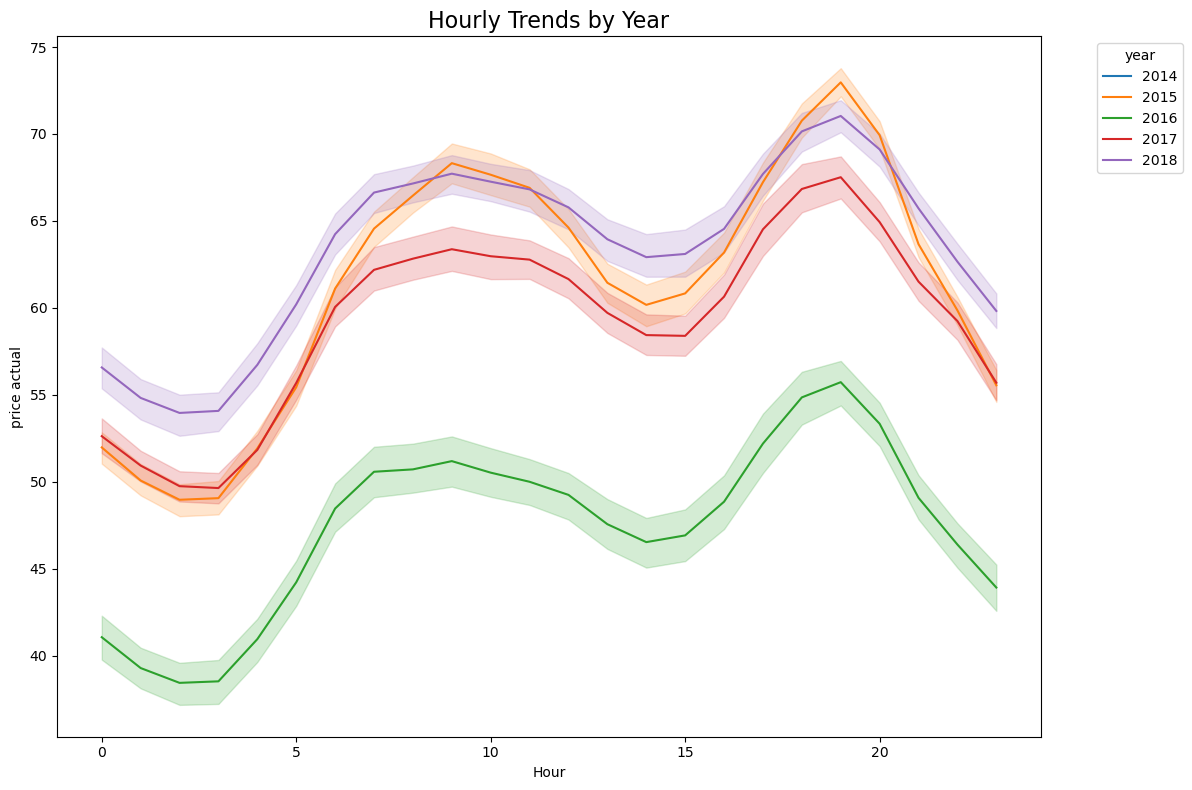

In [ ]:

# If you already have a DatetimeIndex:
# Create a new column for Year and Month
merged_df['hour'] = merged_df.index.hour

# merged_df.columns
# # Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='hour', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Hourly Trends by Year', fontsize=16)
plt.xlabel('Hour')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


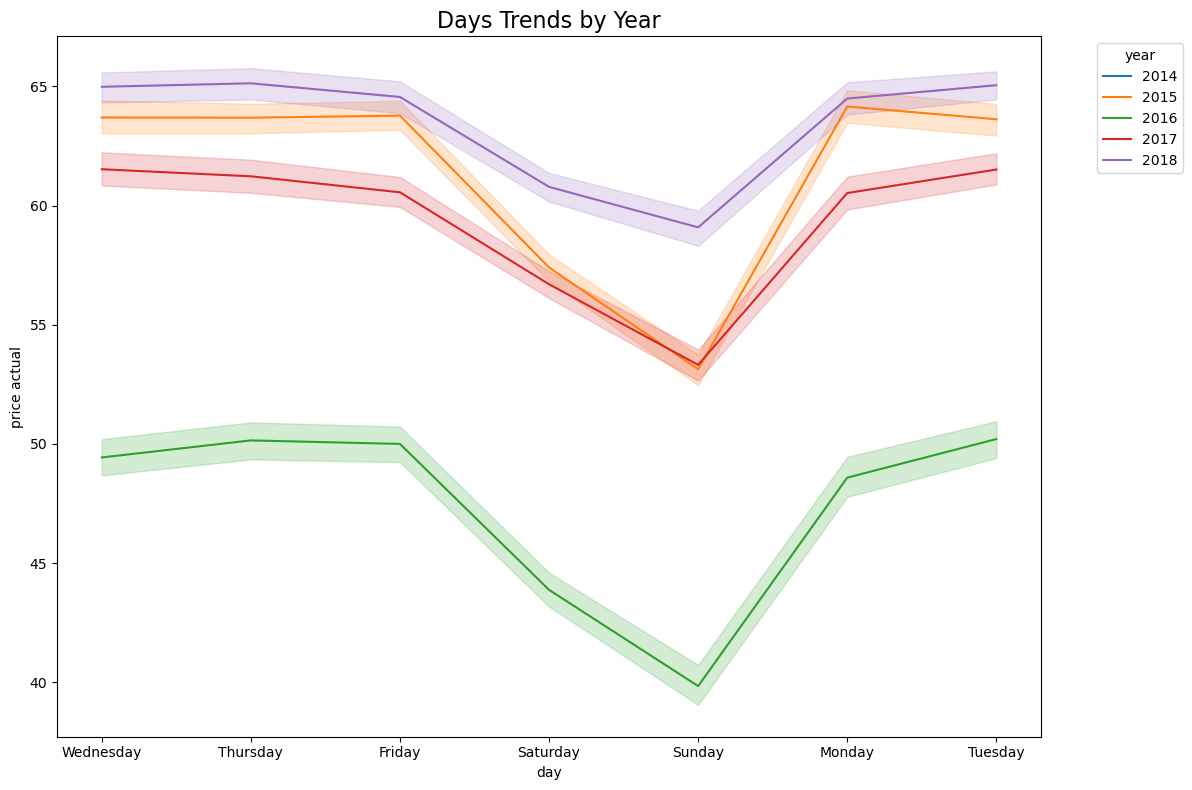

In [ ]:
# Extract the day of the week
merged_df['day'] = merged_df.index.strftime('%A')  # Full day name (e.g., "Monday", "Tuesday")


# merged_df.columns
# # Create the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=merged_df, x='day', y='price actual', hue='year', palette='tab10', legend='full')

# Customize the plot
plt.title('Days Trends by Year', fontsize=16)
plt.xlabel('day')
plt.ylabel('price actual')
plt.legend(title='year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the ADF test on a time series
def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Perform the ADF test on the 'price actual' column
adf_test(merged_df['price actual'])

Results of Dickey-Fuller Test:
Test Statistic                -9.147016e+00
p-value                        2.750493e-15
#Lags Used                     5.000000e+01
Number of Observations Used    3.501300e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


In [40]:
merged_df['is_weekend'] = merged_df['day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


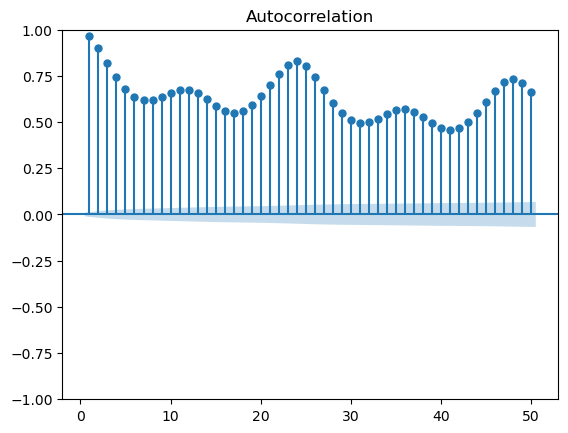

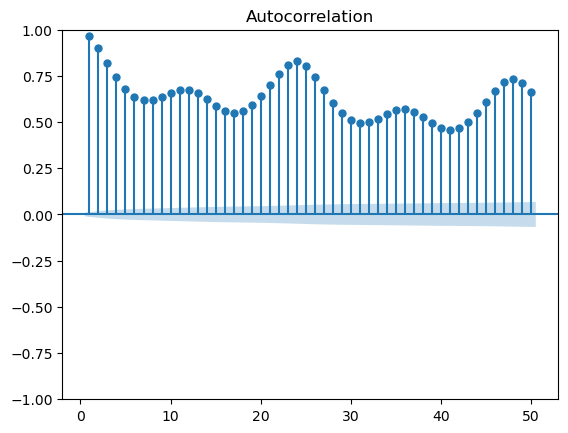

In [ ]:
plot_acf(merged_df['price actual'], lags=50, zero=False)

Autocorrelation (ACF) Plot:

The ACF plot shows the correlation between the time series and its lagged values.
In your plot, we observe a significant spike at lag 0, which is expected.
There are also significant spikes at several other lags, suggesting strong autocorrelation.
The ACF plot doesn't cut off sharply, indicating that it might be challenging to identify a clear pattern for the moving average (MA) component.

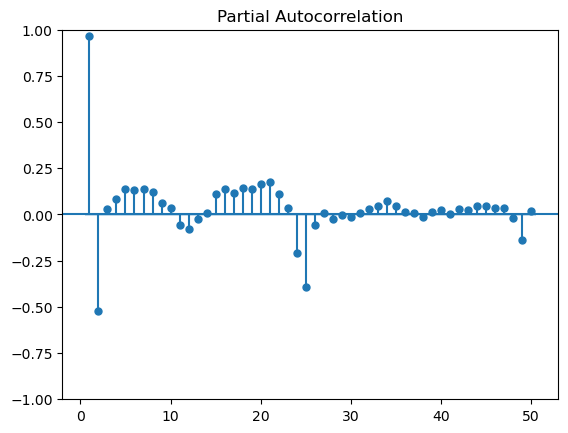

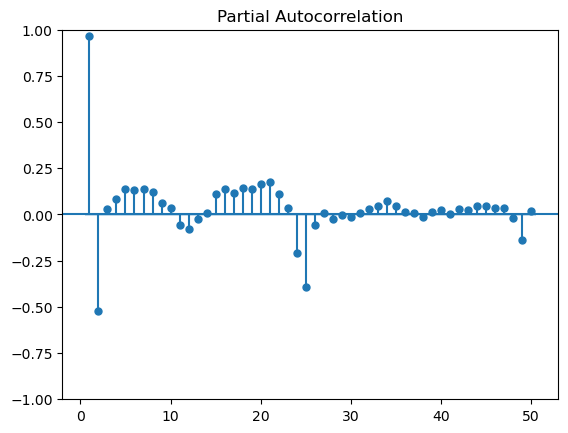

In [ ]:
plot_pacf(merged_df['price actual'], lags=50, zero=False)

Partial Autocorrelation (PACF) Plot:

The PACF plot shows the correlation between the time series and its lagged values, controlling for the effects of intermediate lags.
In your plot, we see a few significant spikes at certain lags. This might suggest a few relevant lags for the autoregressive (AR) component.

In [43]:
tr_start,tr_end = '2015-01-01','2018-10-31'
te_start,te_end = '2018-11-01','2018-12-31'
x0 = merged_df['price actual'][tr_start:tr_end]
x1 = merged_df['price actual'][te_start:te_end]

print(len(x0))
print(len(x1))

33600
1463


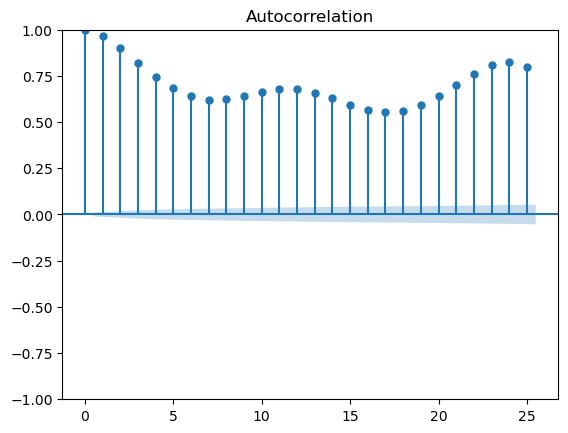

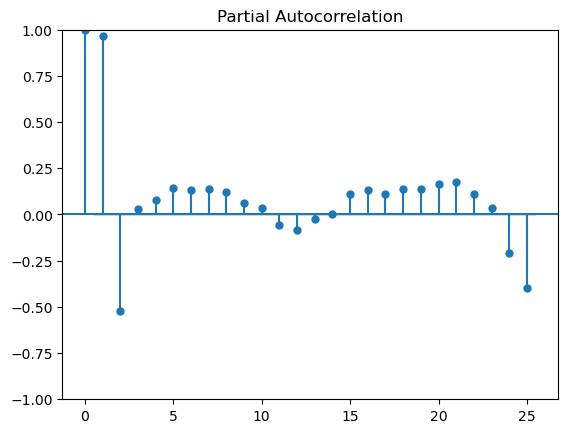

In [ ]:
# examine autocorrelation
plot_acf(x0, lags = 25); print()
plot_pacf(x0, lags = 25); print()

In [45]:
merged_df.columns


Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'city_name_Valencia',
       'temp_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'snow_3h_Valencia', 'clouds_all_Valencia', 'weather_main_Valencia',
       'city_name_Madrid', 'temp_Madrid', 'pressure_Madrid', 'humidity_Madrid',
       'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid',
       'snow_3h_Madrid', 'clouds_all_Madrid', 'weather_main_Madrid',
       'city_name_Bilbao', 't

In [46]:
from pmdarima import preprocessing as ppc
from pmdarima import pipeline
from pmdarima import model_selection


In [47]:
# Assuming merged_df is sorted by time
print(merged_df.columns)
xtrain = merged_df['total load actual'][:-2000]  # All data except the last 2000 points
xvalid = merged_df['total load actual'][-2000:]  # Last 2000 points for validation

# Check the types to ensure they are still Series
print(type(xtrain), type(xvalid))
# Selecting 4-5 features to use as exogenous variables
# Convert 'month' to numeric


# Convert 'day' to numeric (if the 'day' column represents a numeric value, else you may need to adjust)
merged_df['day'] = pd.to_numeric(merged_df['day'], errors='coerce')

exog_train = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual']].iloc[:-2000]


Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'city_name_Valencia',
       'temp_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'snow_3h_Valencia', 'clouds_all_Valencia', 'weather_main_Valencia',
       'city_name_Madrid', 'temp_Madrid', 'pressure_Madrid', 'humidity_Madrid',
       'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid',
       'snow_3h_Madrid', 'clouds_all_Madrid', 'weather_main_Madrid',
       'city_name_Bilbao', 't

In [48]:
import statsmodels.api as sm


In [49]:
# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index)
# Set the frequency of the index to hourly
merged_df = merged_df.asfreq('h')
# Define your train and test periods
tr_start, tr_end = '2015-01-01', '2018-10-31'
te_start, te_end = '2018-11-01', '2018-12-31'

# Select the training and testing data based on the date ranges
train_data = merged_df['price actual'][tr_start:tr_end]
exog_train = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead']][tr_start:tr_end]
exog_test = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead']][te_start:te_end]
test_data = merged_df['price actual'][te_start:te_end]

# Re-align the exogenous data to match the train data index
exog_train = exog_train.loc[train_data.index]

In [ ]:

print(train_data)
# Fit the SARIMAX model
model = sm.tsa.SARIMAX(train_data, exog=exog_train, order=(2, 0, 0), seasonal_order=(2, 0, 0, 12))
model_fit = model.fit()

time
2015-01-01 00:00:00+00:00    64.92
2015-01-01 01:00:00+00:00    64.48
2015-01-01 02:00:00+00:00    59.32
2015-01-01 03:00:00+00:00    56.04
2015-01-01 04:00:00+00:00    53.63
                             ...  
2018-10-31 19:00:00+00:00    84.45
2018-10-31 20:00:00+00:00    86.80
2018-10-31 21:00:00+00:00    72.96
2018-10-31 22:00:00+00:00    73.79
2018-10-31 23:00:00+00:00    74.53
Freq: H, Name: price actual, Length: 33600, dtype: float64


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40960D+00    |proj g|=  6.81022D+01

At iterate    5    f=  2.36574D+00    |proj g|=  2.26833D+00

At iterate   10    f=  2.36497D+00    |proj g|=  1.57856D+00

At iterate   15    f=  2.36321D+00    |proj g|=  2.31949D+00

At iterate   20    f=  2.35537D+00    |proj g|=  2.30777D+01

At iterate   25    f=  2.33575D+00    |proj g|=  2.52767D+00

At iterate   30    f=  2.33557D+00    |proj g|=  2.71877D+00

At iterate   35    f=  2.33436D+00    |proj g|=  4.61241D+00

At iterate   40    f=  2.31969D+00    |proj g|=  1.08376D+01

At iterate   45    f=  2.28027D+00    |proj g|=  3.52692D+00

At iterate   50    f=  2.27826D+00    |proj g|=  9.61431D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
def calculate_rmse(actual, predicted):
    # Ensure that the inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    return rmse

DatetimeIndex(['2018-11-01 00:00:00+00:00', '2018-11-01 01:00:00+00:00',
               '2018-11-01 02:00:00+00:00', '2018-11-01 03:00:00+00:00',
               '2018-11-01 04:00:00+00:00', '2018-11-01 05:00:00+00:00',
               '2018-11-01 06:00:00+00:00', '2018-11-01 07:00:00+00:00',
               '2018-11-01 08:00:00+00:00', '2018-11-01 09:00:00+00:00',
               '2018-11-01 10:00:00+00:00', '2018-11-01 11:00:00+00:00',
               '2018-11-01 12:00:00+00:00', '2018-11-01 13:00:00+00:00',
               '2018-11-01 14:00:00+00:00', '2018-11-01 15:00:00+00:00',
               '2018-11-01 16:00:00+00:00', '2018-11-01 17:00:00+00:00',
               '2018-11-01 18:00:00+00:00', '2018-11-01 19:00:00+00:00',
               '2018-11-01 20:00:00+00:00', '2018-11-01 21:00:00+00:00',
               '2018-11-01 22:00:00+00:00', '2018-11-01 23:00:00+00:00',
               '2018-11-02 00:00:00+00:00', '2018-11-02 01:00:00+00:00',
               '2018-11-02 02:00:00+00:00', '2018-1

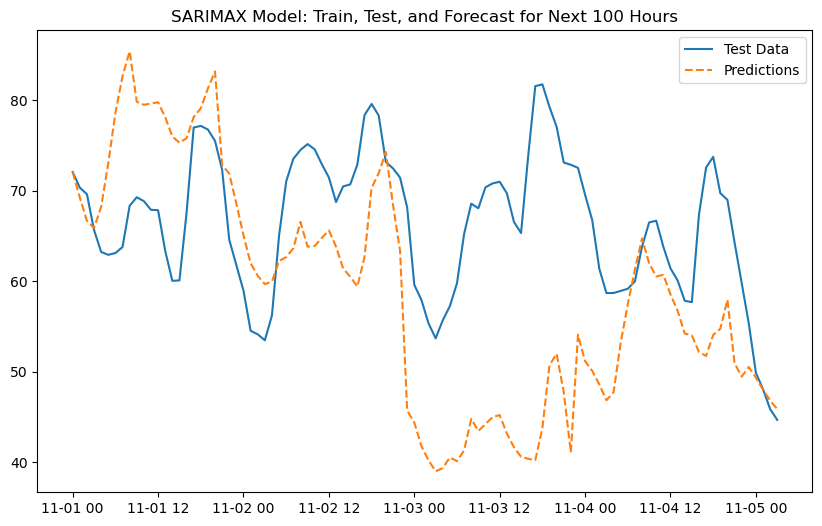

In [ ]:
# Define the forecast period (next 24 hours)
forecast_period = pd.date_range(start=test_data.index[0], periods=100, freq='H')
print(forecast_period)

exog_forecast = merged_df[['generation hydro run-of-river and poundage',
                           'generation hydro water reservoir', 'generation nuclear',
                           'generation other', 'generation other renewable', 'generation solar',
                           'generation waste', 'generation wind onshore', 'total load actual',
                           'price day ahead']].reindex(forecast_period)


print(exog_forecast)
# Make the forecast
predictions = model_fit.forecast(steps=100, exog=exog_forecast)
# Create a time index for the next 100 hours
last_time = test_data.index[-1]  # The last timestamp in your test data
forecast_index = pd.date_range(start=last_time, periods=25, freq='H')[1:]  # 100 hours after the last timestamp
test_100_first_hours = test_data[:100]
forecast_index = test_100_first_hours.index
# Convert the forecast to a DataFrame with the new index
predictions_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted_mean'])
test_100_first_hours = test_data[:100]
print(test_100_first_hours)
print(predictions_df)
# Plot the train and test data
plt.figure(figsize=(10,6))

# Plot the test data (up to the end of the test period)
plt.plot(predictions_df.index, test_100_first_hours, label='Test Data')

# Plot only the predictions for the next 100 hours
plt.plot(predictions_df.index, predictions_df['predicted_mean'], label='Predictions', linestyle='--')

# Add the legend and title
plt.legend()
plt.title('SARIMAX Model: Train, Test, and Forecast for Next 100 Hours')

# Display the plot
plt.show()

In [ ]:
model = sm.tsa.SARIMAX(train_data, exog=exog_train, order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))
model_fit = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48261D+00    |proj g|=  6.64868D+01

At iterate    5    f=  2.44235D+00    |proj g|=  2.76199D+00

At iterate   10    f=  2.44098D+00    |proj g|=  2.29738D+00

At iterate   15    f=  2.43604D+00    |proj g|=  1.91921D+00

At iterate   20    f=  2.41711D+00    |proj g|=  1.27962D+01

At iterate   25    f=  2.34469D+00    |proj g|=  3.11277D+01

At iterate   30    f=  2.34106D+00    |proj g|=  3.84098D+00

At iterate   35    f=  2.33643D+00    |proj g|=  5.01140D+00

At iterate   40    f=  2.29357D+00    |proj g|=  9.35598D+00

At iterate   45    f=  2.27360D+00    |proj g|=  1.04240D+01


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.25700D+00    |proj g|=  1.46116D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     56      1     0     0   1.461D-01   2.257D+00
  F =   2.2570002526628934     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [54]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

merged_df.columns
# Fit and transform the 'day' column
merged_df['day'] = encoder.fit_transform(merged_df['day'])

merged_df['day']

time
2014-12-31 23:00:00+00:00    0
2015-01-01 00:00:00+00:00    0
2015-01-01 01:00:00+00:00    0
2015-01-01 02:00:00+00:00    0
2015-01-01 03:00:00+00:00    0
                            ..
2018-12-31 18:00:00+00:00    0
2018-12-31 19:00:00+00:00    0
2018-12-31 20:00:00+00:00    0
2018-12-31 21:00:00+00:00    0
2018-12-31 22:00:00+00:00    0
Freq: H, Name: day, Length: 35064, dtype: int64

In [55]:
# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index)
# Set the frequency of the index to hourly
merged_df = merged_df.asfreq('h')
# Define your train and test periods
tr_start, tr_end = '2015-01-01', '2018-10-31'
te_start, te_end = '2018-11-01', '2018-12-31'

# Select the training and testing data based on the date ranges
train_data = merged_df['price actual'][tr_start:tr_end]
exog_train = merged_df[['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'city_name_Valencia',
       'temp_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'snow_3h_Valencia', 'clouds_all_Valencia', 'weather_main_Valencia',
       'city_name_Madrid', 'temp_Madrid', 'pressure_Madrid', 'humidity_Madrid',
       'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid',
       'snow_3h_Madrid', 'clouds_all_Madrid', 'weather_main_Madrid',
       'city_name_Bilbao', 'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'weather_main_Bilbao',
       'city_name_ Barcelona', 'temp_ Barcelona', 'pressure_ Barcelona',
       'humidity_ Barcelona', 'wind_speed_ Barcelona', 'wind_deg_ Barcelona',
       'rain_1h_ Barcelona', 'snow_3h_ Barcelona', 'clouds_all_ Barcelona',
       'weather_main_ Barcelona', 'city_name_Seville', 'temp_Seville',
       'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville',
       'wind_deg_Seville', 'rain_1h_Seville', 'snow_3h_Seville',
       'clouds_all_Seville', 'weather_main_Seville', 'year', 'month', 'hour',
       'day', 'is_weekend']][tr_start:tr_end]
exog_test = merged_df[['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'city_name_Valencia',
       'temp_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'snow_3h_Valencia', 'clouds_all_Valencia', 'weather_main_Valencia',
       'city_name_Madrid', 'temp_Madrid', 'pressure_Madrid', 'humidity_Madrid',
       'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid',
       'snow_3h_Madrid', 'clouds_all_Madrid', 'weather_main_Madrid',
       'city_name_Bilbao', 'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'weather_main_Bilbao',
       'city_name_ Barcelona', 'temp_ Barcelona', 'pressure_ Barcelona',
       'humidity_ Barcelona', 'wind_speed_ Barcelona', 'wind_deg_ Barcelona',
       'rain_1h_ Barcelona', 'snow_3h_ Barcelona', 'clouds_all_ Barcelona',
       'weather_main_ Barcelona', 'city_name_Seville', 'temp_Seville',
       'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville',
       'wind_deg_Seville', 'rain_1h_Seville', 'snow_3h_Seville',
       'clouds_all_Seville', 'weather_main_Seville', 'year', 'month', 'hour',
       'day', 'is_weekend']][te_start:te_end]
test_data = merged_df['price actual'][te_start:te_end]

# # Re-align the exogenous data to match the train data index
# exog_train = exog_train.loc[train_data.index]
# print(exog_train.dtypes.unique())
# from sklearn.preprocessing import LabelEncoder

# # Example DataFrame (replace with your exog_train)
# # exog_train = ...
# print(exog_train['day'])
# # Create a LabelEncoder instance
# encoder = LabelEncoder()

# # Iterate over columns in exog_train
# for column in exog_train.columns:
#     # If the column is not numeric (not int or float), attempt to encode it
#     if exog_train[column].dtype not in ['int64', 'float64']:
#         if exog_train[column].dtype == 'O':  # If the column is of type 'object' (categorical)
#             try:
#                 # Attempt to encode categorical data to integers
#                 exog_train[column] = encoder.fit_transform(exog_train[column].astype(str))
#             except Exception as e:
#                 print(f"Error encoding column {column}: {e}")
#         else:
#             # Try to convert non-numeric strings to numbers
#             exog_train[column] = pd.to_numeric(exog_train[column], errors='coerce')

# # Now exog_train should have numeric columns where possible
# print(exog_train.dtypes.unique())


In [ ]:
model = sm.tsa.SARIMAX(train_data, exog=exog_train, order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))
model_fit = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# Define the forecast period (next 24 hours)
forecast_period = pd.date_range(start=test_data.index[0], periods=100, freq='H')
print(forecast_period)

exog_forecast = merged_df[['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'city_name_Valencia',
       'temp_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'snow_3h_Valencia', 'clouds_all_Valencia', 'weather_main_Valencia',
       'city_name_Madrid', 'temp_Madrid', 'pressure_Madrid', 'humidity_Madrid',
       'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid',
       'snow_3h_Madrid', 'clouds_all_Madrid', 'weather_main_Madrid',
       'city_name_Bilbao', 'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'weather_main_Bilbao',
       'city_name_ Barcelona', 'temp_ Barcelona', 'pressure_ Barcelona',
       'humidity_ Barcelona', 'wind_speed_ Barcelona', 'wind_deg_ Barcelona',
       'rain_1h_ Barcelona', 'snow_3h_ Barcelona', 'clouds_all_ Barcelona',
       'weather_main_ Barcelona', 'city_name_Seville', 'temp_Seville',
       'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville',
       'wind_deg_Seville', 'rain_1h_Seville', 'snow_3h_Seville',
       'clouds_all_Seville', 'weather_main_Seville', 'year', 'month', 'hour',
       'day', 'is_weekend']].reindex(forecast_period)


print(exog_test.dtypes.unique())# Make the forecast
predictions = model_fit.forecast(steps=100, exog=exog_forecast)
# Create a time index for the next 100 hours
last_time = test_data.index[-1]  # The last timestamp in your test data
forecast_index = pd.date_range(start=last_time, periods=25, freq='H')[1:]  # 100 hours after the last timestamp
test_100_first_hours = test_data[:100]
forecast_index = test_100_first_hours.index
# Convert the forecast to a DataFrame with the new index
predictions_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted_mean'])
test_100_first_hours = test_data[:100]
print(test_100_first_hours)
print(predictions_df)
# Plot the train and test data
plt.figure(figsize=(10,6))

# Plot the test data (up to the end of the test period)
plt.plot(predictions_df.index, test_100_first_hours, label='Test Data')

# Plot only the predictions for the next 100 hours
plt.plot(predictions_df.index, predictions_df['predicted_mean'], label='Predictions', linestyle='--')

# Add the legend and title
plt.legend()
plt.title('SARIMAX Model: Train, Test, and Forecast for Next 100 Hours')

# Display the plot
plt.show()

DatetimeIndex(['2018-11-01 00:00:00+00:00', '2018-11-01 01:00:00+00:00',
               '2018-11-01 02:00:00+00:00', '2018-11-01 03:00:00+00:00',
               '2018-11-01 04:00:00+00:00', '2018-11-01 05:00:00+00:00',
               '2018-11-01 06:00:00+00:00', '2018-11-01 07:00:00+00:00',
               '2018-11-01 08:00:00+00:00', '2018-11-01 09:00:00+00:00',
               '2018-11-01 10:00:00+00:00', '2018-11-01 11:00:00+00:00',
               '2018-11-01 12:00:00+00:00', '2018-11-01 13:00:00+00:00',
               '2018-11-01 14:00:00+00:00', '2018-11-01 15:00:00+00:00',
               '2018-11-01 16:00:00+00:00', '2018-11-01 17:00:00+00:00',
               '2018-11-01 18:00:00+00:00', '2018-11-01 19:00:00+00:00',
               '2018-11-01 20:00:00+00:00', '2018-11-01 21:00:00+00:00',
               '2018-11-01 22:00:00+00:00', '2018-11-01 23:00:00+00:00',
               '2018-11-02 00:00:00+00:00', '2018-11-02 01:00:00+00:00',
               '2018-11-02 02:00:00+00:00', '2018-1

ValueError: Provided exogenous values are not of the appropriate shape. Required (100, 10), got (100, 71).

In [192]:
def calculate_rmse(actual, predicted):
    # Ensure that the inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    
    return rmse

In [237]:
# Make predictions

predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, exog=exog_test)

# Actual test data values (for comparison)
actual_values = test_data

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [200]:
# Calculate RMSE
rmse_value = calculate_rmse(actual_values, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse_value}")

Root Mean Squared Error (RMSE): 26.72243195615896


In [201]:
rmse_100 = calculate_rmse(test_100_first_hours, predictions_df['predicted_mean'])
print(f"Root Mean Squared Error (RMSE) for the next 100 hours: {rmse_100}")

Root Mean Squared Error (RMSE) for the next 100 hours: 14.911484275442424


In [299]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 100  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 2000  # test set length: any positive integer



In [300]:
new_df = merged_df.copy()[['price actual']]
# Convert into GluonTS dataset
ds = PandasDataset(dict(new_df))
# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set


In [301]:
# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)


/Users/nirdagan/anaconda3/envs/datascience_project/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


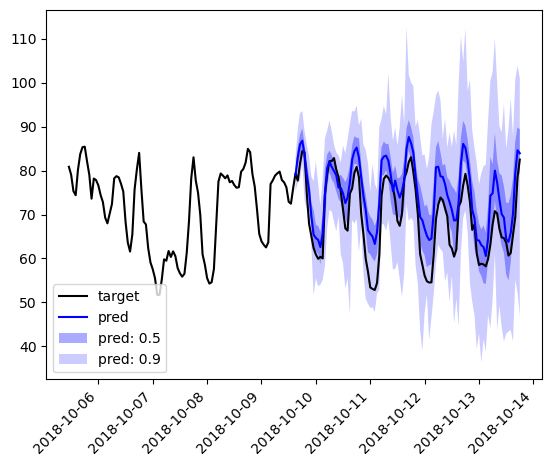

In [302]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=100,
    name="pred",
    show_label=True,
)
plt.show()

In [303]:
# Evaluate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(((actual - predicted) ** 2).mean())



# Extract the predicted values from the forecast (using mean of samples)
forecast_values = forecast.samples.mean(axis=1)  # Taking the mean across all samples (axis=1)
# Calculate RMSE for the current instance
rmse = calculate_rmse(label['target'], forecast_values)
    

# Compute RMSE across all instances
avg_rmse = rmse
print(f"RMSE: {avg_rmse}")


RMSE: 11.598834985128706


In [305]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper


In [322]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
T = df.shape[0]
df["dynamic_real_1"] = np.random.normal(size=T)
df["past_dynamic_real_2"] = np.random.normal(size=T)
print(df['item_id'].dtype)


object


In [ ]:
# Assuming df is your DataFrame
non_numeric_columns = merged_df.select_dtypes(exclude=['float64', 'int64', 'int32'])
print(non_numeric_columns.columns)


for_multi_ts = merged_df.copy()
for_multi_ts.drop(['city_name_Valencia', 'city_name_Madrid', 'city_name_Bilbao',
       'city_name_ Barcelona', 'city_name_Seville'],axis=1,inplace=True)

for_multi_ts['target'] = for_multi_ts['price actual']
for_multi_ts.drop(['price actual'],axis=1,inplace=True)
for_multi_ts['item_id'] = 1
print(for_multi_ts['item_id'].dtype)
ds = PandasDataset(dict(for_multi_ts))

# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

Index(['city_name_Valencia', 'city_name_Madrid', 'city_name_Bilbao',
       'city_name_ Barcelona', 'city_name_Seville', 'month'],
      dtype='object')
int64


NameError: name 'PandasDataset' is not defined

In [326]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [ ]:
# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)